# MC: 蒙特卡洛方法
## 1. simple rejection sampling

In [3]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
%matplotlib inline 

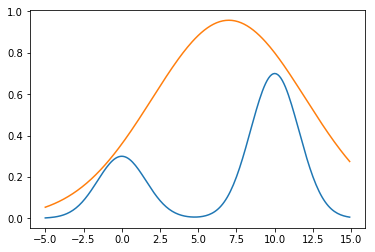

In [127]:
# unnormal p_t
f_t = lambda z: 0.3 * np.exp(-0.2 * z ** 2) + 0.7 * np.exp(-0.2 * (z - 10) ** 2)
q_z = partial(norm.pdf, loc=7, scale=5)
M = 12
X = np.arange(-5, 15, 0.1)
plt.plot(X, f_t(X))
plt.plot(X, M*q_z(X))


total 100000 ac 1118 rj 998882


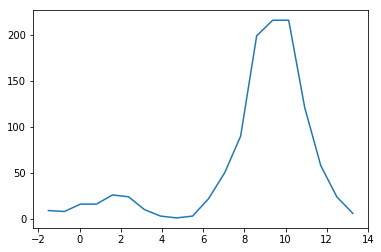

In [128]:
rj, ac = 0, 0  #count
samples = []
for _ in range(1000000):
    u = np.random.uniform()
    x = norm.rvs(loc=7, scale=5)
    if u < f_t(x) / M * q_z(x):
        ac += 1
        samples.append(x)
    else:
        rj += 1

l_ = len(samples)
histogram, bins = np.histogram(samples, 20)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, histogram)
print('total {} ac {} rj {}'.format(100000, ac, rj))

*Notes*:
> 1. 接受率很低，受维度灾难影响大，无法扩展到高维。
> 2. q_z 必须是一个能容易采样的概率分布， p_z 可以不用归一化

## 2. simple importance sampling

### p_z和q_z都是概率分布

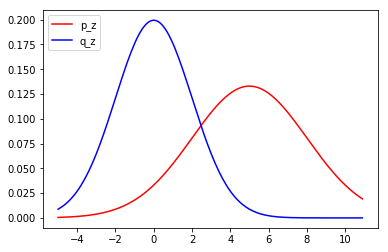

In [129]:
p_z = partial(norm.pdf, loc=5, scale=3)
q_z = partial(norm.pdf, loc=0, scale=2)
f = lambda x: x
X = np.arange(-5, 11, 0.1)
plt.plot(X, p_z(X), color='red', label='p_z')
plt.plot(X, q_z(X), color='blue', label='q_z')
# plt.plot(X, f(X), color='green', label='f_z')
plt.legend(loc='upper left')


*评估期望*$\mathcal{E}[f]$

In [155]:
L = 1000000
# 从q_z中采L个样本,loc=0, scale=2
q_samples = norm.rvs(size=L, loc=0, scale=2)
q_q = q_z(q_samples)
p_q = p_z(q_samples)
f_z = f(q_samples)
w = p_q / q_q
e_f_p = np.mean(w * f_z)

print('E[f]: {}'.format(e_f_p))


E[f]: 4.98131555610797


*Notes:*
> 1. 为保证采样的有效性，p_z 和 q_z 的分布应该有‘充分’的重叠区域。
> 2. 重要性采样本身并没有提供从p_z中采样的方法。
> 3. 对维度灾难敏感

*从p_z中采样：sampling-importance-resampling*
> stage1: $z1, ... , zL \sim q_z$  
> stage2: constructed w1, ... ,wL  
> stage3: choice(z, w, replace=True)  

E[f]: 4.963735167875567, Var: 2.89117180244722


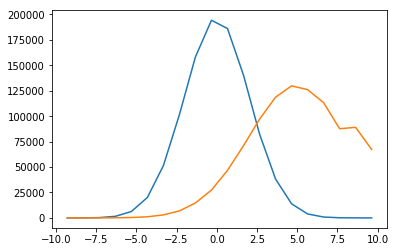

In [159]:
q_resamples = np.random.choice(q_samples, len(q_samples), True, w/np.sum(w))
hist1, bins1 = np.histogram(q_samples, 20)
bins1 = 0.5 * (bins1[1:] + bins1[:-1])
plt.plot(bins1, hist1)
hist2, bins2 = np.histogram(q_resamples, 20)
bins2 = 0.5 * (bins2[1:] + bins2[:-1])
plt.plot(bins2, hist2)

e_fp = np.mean(q_resamples)
v_fp = np.sqrt(np.var(q_resamples))
print('E[f]: {}, Var: {}'.format(e_fp, v_fp))


### p_z是非归一化的概率， q_z是归一化的概率分布

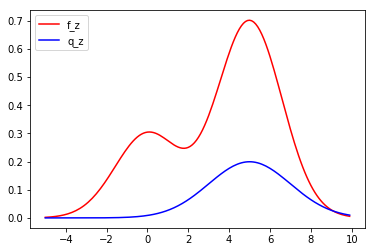

In [161]:
# 用f_z表示未归一化的概率
f_z = lambda z: 0.3 * np.exp(-0.2 * z ** 2) + 0.7 * np.exp(-0.2 * (z - 5) ** 2)
q_z = partial(norm.pdf, loc=5, scale=2)
X = np.arange(-5, 10, 0.1)
plt.plot(X, f_z(X), color='red', label='f_z')
plt.plot(X, q_z(X), color='blue', label='q_z')
plt.legend(loc='upper left')

In [167]:
L = 1000000
# 从q_z中采L个样本,loc=0, scale=2
q_samples = norm.rvs(size=L, loc=5, scale=2)
q_q = q_z(q_samples)
p_q = f_z(q_samples)
r = p_q / q_q   # 未归一化的概率比用r表示

估计p_z的配分函数$\frac{Z_p}{Z_q} \simeq \frac{1}{L}\sum_{l=1}^{L}r_l$, 由于q_z我们取的概率分布，所以$Z_q=1$. 

In [168]:
Z_p = np.mean(r)
print('配分函数Z_p：{}'.format(Z_p))

配分函数Z_p：3.963448330280565


估计p_z的期望:

In [169]:
w = r / np.sum(r)
f = lambda x: x
E_p = np.sum(w * f(q_samples))
print('期望E_p: {}'.format(E_p))

期望E_p: 3.5000260141828137


*importance resampling*

E[f]: 3.498871520021568, Var: 2.7763463280053813


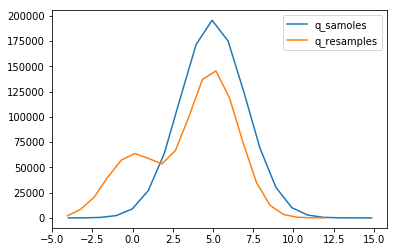

In [172]:
q_resamples = np.random.choice(q_samples, len(q_samples), True, w/np.sum(w))
hist1, bins1 = np.histogram(q_samples, 20)
bins1 = 0.5 * (bins1[1:] + bins1[:-1])
plt.plot(bins1, hist1, label='q_samoles')
hist2, bins2 = np.histogram(q_resamples, 20)
bins2 = 0.5 * (bins2[1:] + bins2[:-1])
plt.plot(bins2, hist2, label='q_resamples')
plt.legend()

e_fp = np.mean(q_resamples)
v_fp = np.sqrt(np.var(q_resamples))
print('E[f]: {}, Var: {}'.format(e_fp, v_fp))

## Metropolis-Hastings

---------- scale: 1-----------


期望E_p：3.545178367732732 方差V_p: 2.7980270356188996
---------- scale: 5-----------


期望E_p：3.5004761675289915 方差V_p: 2.707262580239132
---------- scale: 10-----------


期望E_p：3.395947975033237 方差V_p: 2.8055361848005953


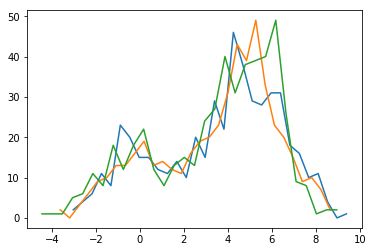

In [13]:
def MH(n_samples, f_z, t_rvs, t_pdf):
    def T_(x, iter=200):
        for _ in range(iter):
            x_pre = t_rvs(x)
            a = f_z(x_pre) * t_pdf(x, x_pre) / f_z(x) / t_pdf(x_pre, x)
            u = np.random.uniform()
            if u < a:
                x = x_pre
        return x
    
    samples = []
    for _ in range(n_samples):
        x0 = t_rvs(0)
        x = T_(x0)
        samples.append(x)
    return samples

def test_MH(n_samples, f_z, t_rvs, t_pdf, label):
    samples = MH(n_samples, f_z, t_rvs, t_pdf)
    E_p = np.mean(samples)
    V_p = np.sqrt(np.var(samples))
    print('期望E_p：{} 方差V_p: {}'.format(E_p, V_p))
    hists, bins = np.histogram(samples, 30)
    bins = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bins, hists, label=label)

f_z = lambda z: 0.3 * np.exp(-0.2 * z ** 2) + 0.7 * np.exp(-0.2 * (z - 5) ** 2)
for scale in [1, 5, 10]:
    t_rvs = lambda x: norm.rvs(loc=x, scale=scale)
    t_pdf = lambda x, loc: norm.pdf(x, loc=loc, scale=scale)
    print('---------- scale: {}-----------'.format(scale))
    test_MH(500, f_z, t_rvs, t_pdf, 'scale_{}'.format(scale))
